In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Data Initializing**

In [ ]:
import pandas as pd

df = pd.read_csv('/content/gdrive/MyDrive/skripsi_chandra/ABSA_satisfaction.csv')
df.head()

,review_token,Satisfaction
0,"[7, 36, 62, 27, 269, 26, 6, 97, 334, 7, 288, 2...",0
1,"[293, 74, 1, 913, 107, 80, 4, 19, 186, 15, 198...",0
2,"[2, 87, 17, 107, 137, 213, 89, 2, 82, 6, 53, 3...",0
3,"[2, 14, 12, 33, 519, 41, 4, 50, 25, 19, 68, 68...",1
4,"[74, 6, 53, 25, 61, 144, 4, 28, 797, 65, 218, ...",0


In [ ]:
print(type(df['Satisfaction'][0]))
print(type(df['review_token'][0]))

<class 'numpy.int64'>
<class 'str'>


In [ ]:
df['review_token'] = df['review_token'].map(lambda x: list(map(int, x[1:-1].split(', '))))

In [ ]:
print(type(df['Satisfaction'][0]))
print(type(df['review_token'][0]))

<class 'numpy.int64'>
<class 'list'>


In [ ]:
reviews = df[['review_token']]
labels = df['Satisfaction']

## **Splitting Data and Applying Padding**

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(reviews, labels, test_size=0.3, random_state=42, stratify=labels)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape)

(4536, 1) (972, 1) (972, 1) (4536,) (972,) (972,)


In [ ]:
x_train_pad = x_train['review_token']
x_val_pad = x_val['review_token']
x_test_pad = x_test['review_token']

In [ ]:
from keras.preprocessing import sequence
from keras.utils import pad_sequences

x_train = pad_sequences(x_train_pad, maxlen=100)
x_val = pad_sequences(x_val_pad, maxlen=100)
x_test = pad_sequences(x_test_pad, maxlen=100)

## **Modeling Initialization**

In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.7 MB/s eta 0:00:00


In [ ]:
import numpy as np

embedding_matrix = np.load('/content/gdrive/MyDrive/skripsi_chandra/embedding_matrix.npy')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(restore_best_weights=True, patience=3,
                               min_delta=0.01, monitor='val_loss')

**Hyperparameter tuning**
1. Filter Size [2], [2,3,4]
3. Dropout Rate [0.25, 0.5]
4. Learning Rate [0.001, 0.0001]

## **CNN**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Dropout, Activation, MaxPooling1D, Flatten, Embedding
from tensorflow.keras import optimizers, regularizers

def build_CNN(hp):
  model = Sequential()
  model.add(Embedding(input_dim=2500, output_dim=300,
                      weights=[embedding_matrix], input_length=100))

  filter_sizes = hp.Choice('filter size', values=['2', '2,3,4'])
  filter_sizes_list = [int(x) for x in filter_sizes.split(',')]
  dropout_rate = hp.Choice('dropout rate', values=[0.25, 0.5])
  learn_rate = hp.Choice('learning rate', values=[0.001, 0.0001])

  conv_layers = []
  for filter_size in filter_sizes_list:
    conv_layer = Conv1D(filters=200, kernel_size=filter_size,
                        padding='valid', activation='relu', strides=1)
    conv_layers.append(conv_layer)

  for conv_layer in conv_layers:
    model.add(conv_layer)

  model.add(MaxPooling1D())
  model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dropout(dropout_rate))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizers.Adam(learning_rate=learn_rate), loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
from keras_tuner import GridSearch
from kerastuner.engine.hyperparameters import HyperParameters

tuner = GridSearch(
    build_CNN,
    objective='val_accuracy',
    directory='satisfaction_CNN',
    project_name='satisfaction'
)

tuner.search(x_train, y_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_val,y_val), callbacks=[early_stopping])
tuner.results_summary()

Trial 8 Complete [00h 00m 30s]
val_accuracy: 0.9423868060112

Best val_accuracy So Far: 0.951646089553833
Total elapsed time: 00h 03m 41s
Results summary
Results in satisfaction_CNN/satisfaction
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0006 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.5
learning rate: 0.001
Score: 0.951646089553833

Trial 0004 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.25
learning rate: 0.001
Score: 0.9495884776115417

Trial 0005 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.25
learning rate: 0.0001
Score: 0.9444444179534912

Trial 0003 summary
Hyperparameters:
filter size: 2
dropout rate: 0.5
learning rate: 0.0001
Score: 0.9423868060112

Trial 0007 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.5
learning rate: 0.0001
Score: 0.9423868060112

Trial 0000 summary
Hyperparameters:
filter size: 2
dropout rate: 0.25
learning rate: 0.001
Score: 0.9403291940689087

Trial 0002 summa

In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hp.values

{'filter size': '2,3,4', 'dropout rate': 0.5, 'learning rate': 0.001}

In [ ]:
model = build_CNN(best_hp)
history = model.fit(x_train, y_train,
                    epochs=50, batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping])
model.summary()

Epoch 1/50
71/71 [==============================] - 10s 109ms/step - loss: 1.2337 - accuracy: 0.7665 - val_loss: 0.5115 - val_accuracy: 0.9259
Epoch 2/50
71/71 [==============================] - 4s 52ms/step - loss: 0.3183 - accuracy: 0.9429 - val_loss: 0.2619 - val_accuracy: 0.9372
Epoch 3/50
71/71 [==============================] - 2s 26ms/step - loss: 0.1622 - accuracy: 0.9614 - val_loss: 0.2062 - val_accuracy: 0.9444
Epoch 4/50
71/71 [==============================] - 2s 26ms/step - loss: 0.0972 - accuracy: 0.9764 - val_loss: 0.1800 - val_accuracy: 0.9465
Epoch 5/50
71/71 [==============================] - 1s 14ms/step - loss: 0.0732 - accuracy: 0.9826 - val_loss: 0.1953 - val_accuracy: 0.9414
Epoch 6/50
71/71 [==============================] - 1s 15ms/step - loss: 0.0628 - accuracy: 0.9835 - val_loss: 0.2105 - val_accuracy: 0.9465
Epoch 7/50
71/71 [==============================] - 1s 15ms/step - loss: 0.0470 - accuracy: 0.9892 - val_loss: 0.2246 - val_accuracy: 0.9475
Model: "seq

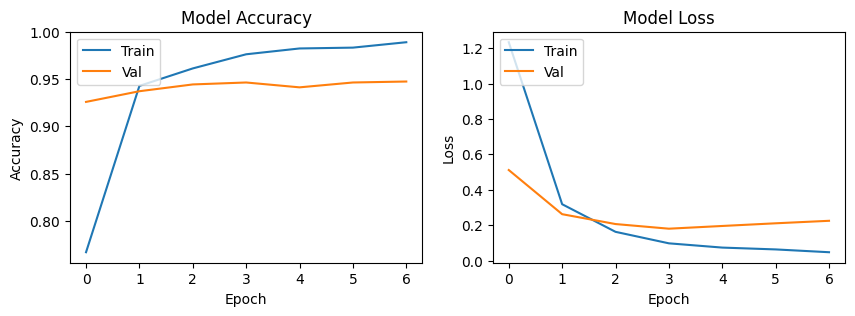

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Val')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')

ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Val')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper left')

plt.show()

In [ ]:
model.save('satisfaction_CNN.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predictions = model.predict(x_test)

31/31 [==============================] - 0s 2ms/step


In [ ]:
y_pred = predictions >= 0.5

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f"Macro-Average Precision: {macro_precision}")
print(f"Macro-Average Recall: {macro_recall}")
print(f"Macro-Average F1 Score: {macro_f1}")

Macro-Average Precision: 0.9537073257467994
Macro-Average Recall: 0.9464302116547914
Macro-Average F1 Score: 0.9496614455640829


In [ ]:
from sklearn.metrics import classification_report

labels = ["Negative", "Positive"]
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       573
           1       0.96      0.92      0.94       399

    accuracy                           0.95       972
   macro avg       0.95      0.95      0.95       972
weighted avg       0.95      0.95      0.95       972



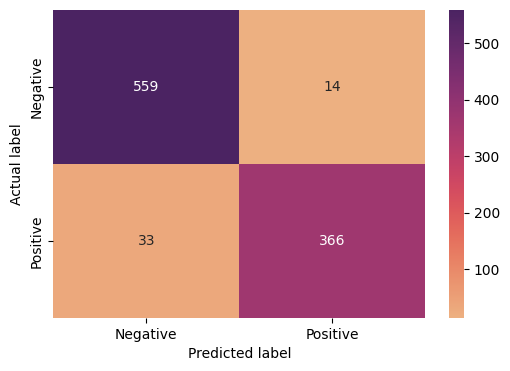

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='flare', fmt='d')
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.show()

# **CNN-LSTM**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Dropout, Activation, MaxPooling1D, Flatten, Embedding
from tensorflow.keras import optimizers, regularizers

def build_CNNLSTM(hp):
  model = Sequential()
  model.add(Embedding(input_dim=2500, output_dim=300,
                      weights=[embedding_matrix], input_length=100))

  filter_sizes = hp.Choice('filter size', values=['2', '2,3,4'])
  filter_sizes_list = [int(x) for x in filter_sizes.split(',')]
  dropout_rate = hp.Choice('dropout rate', values=[0.25, 0.5])
  learn_rate = hp.Choice('learning rate', values=[0.001, 0.0001])

  conv_layers = []
  for filter_size in filter_sizes_list:
    conv_layer = Conv1D(filters=200, kernel_size=filter_size,
                        padding='valid', activation='relu', strides=1)
    conv_layers.append(conv_layer)

  for conv_layer in conv_layers:
    model.add(conv_layer)

  model.add(MaxPooling1D())
  model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dropout(dropout_rate))
  model.add(LSTM(64))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizers.Adam(learning_rate=learn_rate), loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
from keras_tuner import GridSearch
from kerastuner.engine.hyperparameters import HyperParameters

tuner = GridSearch(
    build_CNNLSTM,
    objective='val_accuracy',
    directory='satisfaction_CNNLSTM',
    project_name='satisfaction'
)

tuner.search(x_train, y_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_val,y_val), callbacks=[early_stopping])
tuner.results_summary()

Trial 8 Complete [00h 00m 41s]
val_accuracy: 0.9495884776115417

Best val_accuracy So Far: 0.9557613134384155
Total elapsed time: 00h 04m 48s
Results summary
Results in satisfaction_CNNLSTM/satisfaction
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0006 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.5
learning rate: 0.001
Score: 0.9557613134384155

Trial 0001 summary
Hyperparameters:
filter size: 2
dropout rate: 0.25
learning rate: 0.0001
Score: 0.9537037014961243

Trial 0004 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.25
learning rate: 0.001
Score: 0.9537037014961243

Trial 0002 summary
Hyperparameters:
filter size: 2
dropout rate: 0.5
learning rate: 0.001
Score: 0.951646089553833

Trial 0003 summary
Hyperparameters:
filter size: 2
dropout rate: 0.5
learning rate: 0.0001
Score: 0.951646089553833

Trial 0005 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.25
learning rate: 0.0001
Score: 0.9506173133850098

Trial 0

In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hp.values

{'filter size': '2,3,4', 'dropout rate': 0.5, 'learning rate': 0.001}

In [ ]:
model = build_CNNLSTM(best_hp)
history = model.fit(x_train, y_train,
                    epochs=50, batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping])
model.summary()

Epoch 1/50
71/71 [==============================] - 11s 108ms/step - loss: 1.1765 - accuracy: 0.8062 - val_loss: 0.4649 - val_accuracy: 0.9362
Epoch 2/50
71/71 [==============================] - 4s 59ms/step - loss: 0.2888 - accuracy: 0.9504 - val_loss: 0.2031 - val_accuracy: 0.9465
Epoch 3/50
71/71 [==============================] - 3s 47ms/step - loss: 0.1269 - accuracy: 0.9696 - val_loss: 0.1630 - val_accuracy: 0.9516
Epoch 4/50
71/71 [==============================] - 2s 32ms/step - loss: 0.0859 - accuracy: 0.9784 - val_loss: 0.1899 - val_accuracy: 0.9434
Epoch 5/50
71/71 [==============================] - 1s 18ms/step - loss: 0.0688 - accuracy: 0.9808 - val_loss: 0.1788 - val_accuracy: 0.9444
Epoch 6/50
71/71 [==============================] - 1s 20ms/step - loss: 0.0554 - accuracy: 0.9857 - val_loss: 0.1978 - val_accuracy: 0.9475
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #  

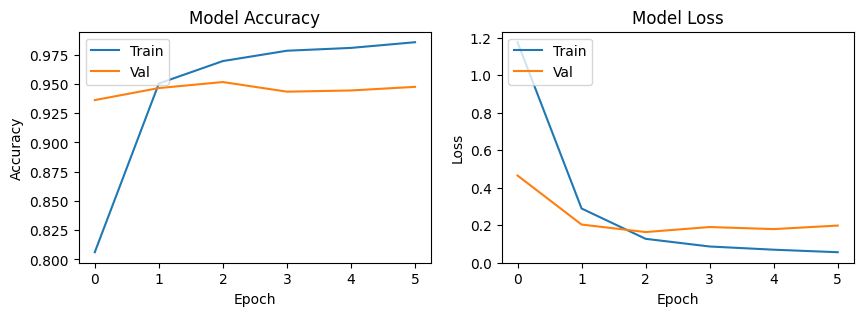

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Val')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')

ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Val')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper left')

plt.show()

In [ ]:
model.save('satisfaction_CNNLSTM.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predictions = model.predict(x_test)

31/31 [==============================] - 1s 3ms/step


In [ ]:
y_pred = predictions >= 0.5

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f"Macro-Average Precision: {macro_precision}")
print(f"Macro-Average Recall: {macro_recall}")
print(f"Macro-Average F1 Score: {macro_f1}")

Macro-Average Precision: 0.9627813155084444
Macro-Average Recall: 0.9605952052907136
Macro-Average F1 Score: 0.9616477272727273


In [ ]:
from sklearn.metrics import classification_report

labels = ["Negative", "Positive"]
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       573
           1       0.96      0.95      0.95       399

    accuracy                           0.96       972
   macro avg       0.96      0.96      0.96       972
weighted avg       0.96      0.96      0.96       972



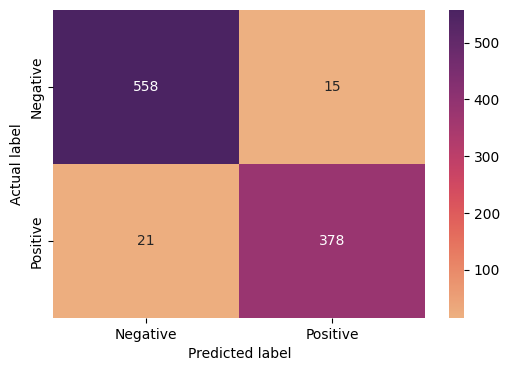

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='flare', fmt='d')
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.show()